In [67]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
# reading names file
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# mappings from integers to strings and vv
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [68]:
# build dataset with train and test split

def build_dataset(words):
    block_size = 3 # how many chars taken to predict the next char
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [ ]:
# lookup table
C = torch.randn((27, 2))

In [ ]:
C

In [ ]:
emb = C[X]
emb.shape

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [ ]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [ ]:
h #output of layer 1

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2 # output of layer 2

In [ ]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

In [ ]:
# -------------Compacting Code-------------

In [120]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # lookup table
W1 = torch.randn((30, 200), generator=g) # layer with 6 inputs into 100 neurons (outputs)
b1 = torch.randn(200, generator=g) # biases for each neuron in l1
W2 = torch.randn((200, 27), generator=g) # layer with 100 inputs (from the 100 outputs of last layer) and 27 neurons (outputs)
b2 = torch.randn(27, generator=g) # biases for each neuron in l2
parameters = [C, W1, b1, W2, b2]

In [116]:
sum(p.nelement() for p in parameters) # total number of parameters

11897

In [121]:
for p in parameters:
    p.requires_grad = True

In [76]:
lre = torch.linspace(-3, 0, 1000) # creates a torch tensor of 1000 evenly spaced learning rates between -3 and 0
lrs = 10**lre # same amount of learning rates, just spaced expenentially now

In [122]:
lri = []
lossi = []
stepi = []

In [123]:
for i in range(200000):

    # minibatch construct. Makes training faster / more efficient
    # splits training data into bacthes and only forward / backward passes for each batch instead on for every sample
    ix = torch.randint(0, Xtr.shape[0], (32, )) # taking 32 rows of X at a time
    # approximates gradients and takes more steps in grad. descent rather than calculating exact grad and taking less steps
    
    # forward pass
    emb = C[Xtr[ix]] # embedded training data. Makes it easier for NN to understand
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # output of l1. Embedded inputs * weights + biases passed through tanh activation
    logits = h @ W2 + b2 # l2 output before activation. L1 output * weights + biases
    # counts = logits.exp() # exponentiated logits. Numerator of softmax activation
    # prob = counts / counts.sum(1, keepdims=True) # outputs of NN. Last step of softmax activation
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix]) # same thing as commented lines above but much more efficient
    
    # backward pass
    for p in parameters:
        p.grad = None # always set gradients to none before a backward pass so they don't keep stacking and inflate learning rate
    loss.backward()
    
    # update params
    lr = 0.1 if i < 100000 else 0.01  # switches learning rate at 100000 steps in order to be more accurate
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracks stats for each learning rate
#     lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

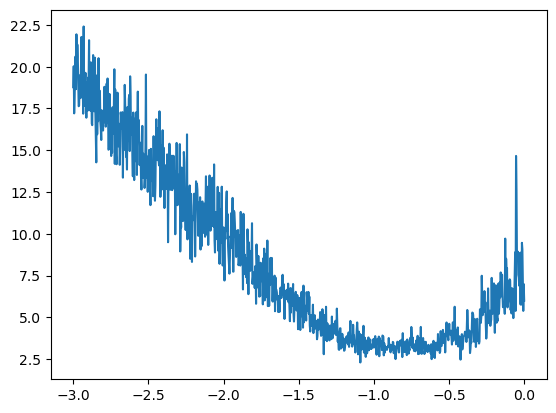

In [52]:
plt.plot(lri, lossi) # how to visualize about what learning rate is the best

In [124]:
# test loss on whole training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1279, grad_fn=<NllLossBackward0>)

In [125]:
# test loss on whole training set
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1624, grad_fn=<NllLossBackward0>)

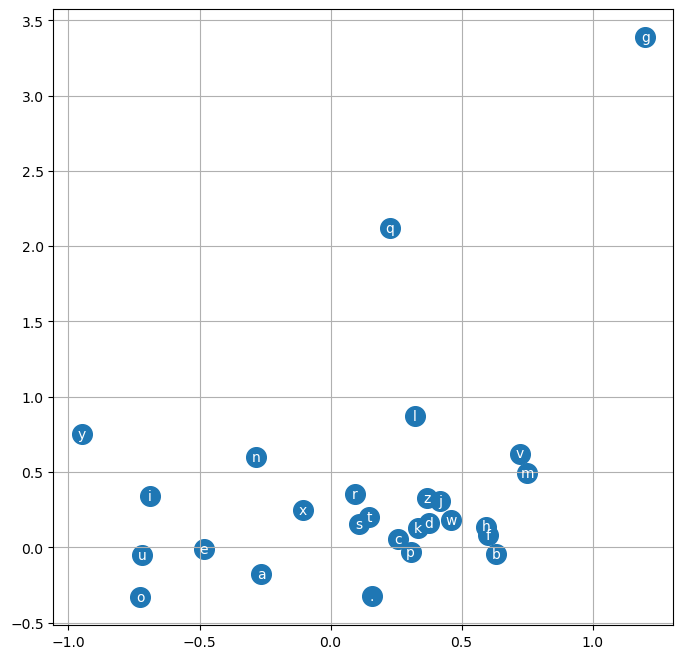

In [100]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')